In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
%matplotlib inline

In [3]:
def rescale(x,xmax,xmin):
    rx = np.zeros(len(x))
    xminval = np.min(x)
    xmaxval = np.max(x)
    for i in range(len(x)):
        rx[i] = (x[i]-xminval)/(xmaxval-xminval)*(xmax-xmin)+xmin
    return rx
# using numpy's histogram2d to calculate the mutual information between two sequences
def mi_quick(a,b,d,bn=25):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,1e-100) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,1e-100) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    nxy[nxy==0] = 1e-100
    return np.sum(xy*np.log2(nxy))

In [4]:
def ConeOutput(x,phi):
    dt=0.01
    alpha_c=-9.602*10**-6
    beta_c=-1.148*10**-5
    alpha_h=0.177
    gamma=0.764
    tau_h=0.371
    tau_z=0.5769
    tau_y=0.056
    Tk=np.arange(0,5,dt)
    Ky=Tk*np.exp(-Tk/tau_y)/tau_y**2 # linear filter for low pass filter
    Kz=gamma*Ky+(1-gamma)*Tk*np.exp(-Tk/tau_z)/tau_z**2 # linear filter for adaptation
    Kh=Tk*np.exp(-Tk/tau_h)/tau_h**2
# y
    y=np.convolve(x,Ky,'full')
    y=y[0:len(x)]
# z
    z=np.convolve(x,Kz,'full')
    z=z[0:len(x)]
    plt.plot(Ky)
    plt.plot(Kz)
    # cone differential equation (include horizontal feedback)
#     phi=1
    r=np.zeros(len(x))
    h=np.zeros(len(x))
    for i in range(len(x)-1): # the length of kernel should be i, original length of kernel is len(Kh)
        Kht=np.zeros(len(x))
        r[i]=alpha_c*y[i]/[1+beta_c*z[i]]-phi*h[i]
        if i-len(Kh)+1<0:
            Kht[0:i+1]=Kh[::-1][-i-1:len(Kh)]
        else:
            Kht[i-len(Kh)+1:i+1]=Kh[::-1]
        h[i+1]=alpha_h*sum(Kht*r)
#     plt.plot(Kht)
    return r,h

In [5]:
# OU
Tot=100
dt=0.01
T=np.arange(dt,Tot,dt)
tau=0.5
D = 4
x=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    x[i+1]=x[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)

(50, 70)

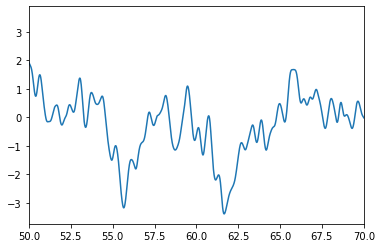

In [6]:
# filtering
fc=2
b, a = signal.butter(2, 2*fc*dt, btype='low', analog=False)
x = signal.filtfilt(b, a, x)
plt.plot(T,x)
plt.xlim(50,70)

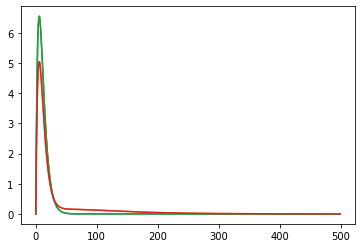

In [7]:
# two outputs with and without horizontal feedback
r,h=ConeOutput(x,1)
r_block,h_block=ConeOutput(x,0)

plt.plot(T,x/np.std(x))
plt.plot(T,r/np.std(r))
plt.plot(T,h/np.std(h))
plt.legend(('x/$\sigma_x$', 'r/$\sigma_r$', 'h/$\sigma_h$'))
plt.xlabel('time (s)')
plt.xlim(40,48)
plt.savefig('F:/我的雲端硬碟/Retina exp/python code/Drinnenberg 2018/x_r_h.pdf')

In [8]:
xr_corr=signal.correlate(x,r,mode='same')
xr_block_xorr=signal.correlate(x,r_block,mode='same')
abs_corr=xr_corr**2
abs_block_corr=xr_block_xorr**2

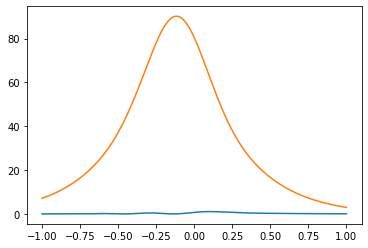

In [9]:
timeshift=np.arange(-1,1.00001,dt)
maxstep=(len(timeshift)-1)/2
middle_index=(len(xr_corr)+1)/2
plt.plot(timeshift,abs_corr[int(middle_index-maxstep):int(middle_index+maxstep)+1])
plt.plot(timeshift,abs_block_corr[int(middle_index-maxstep):int(middle_index+maxstep)+1])
# plt.plot(timeshift,xr_corr[int(middle_index-maxstep):int(middle_index+maxstep)+1])

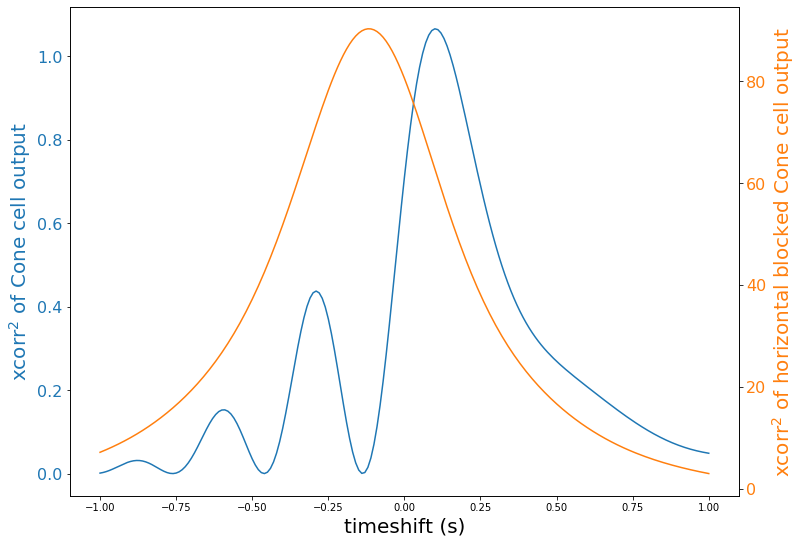

In [10]:
# plot again
fig, ax1=plt.subplots(figsize=(12,9))
c1 = 'tab:blue'
ax1.set_xlabel('timeshift (s)', fontsize=20)
ax1.set_ylabel('xcorr$^2$ of Cone cell output', fontsize=20,color=c1)
ax1.plot(timeshift,abs_corr[int(middle_index-maxstep):int(middle_index+maxstep)+1],color=c1)
ax1.tick_params(axis='y',labelsize=16,labelcolor=c1)

ax2 = ax1.twinx() 
c2= 'tab:orange'
ax2.set_xlabel('timeshift (s)', fontsize=20)
ax2.set_ylabel('xcorr$^2$ of horizontal blocked Cone cell output', fontsize=20,color=c2)
ax2.plot(timeshift,abs_block_corr[int(middle_index-maxstep):int(middle_index+maxstep)+1],color=c2)
ax2.tick_params(axis='y',labelsize=16,labelcolor=c2)
plt.show()

#fig.savefig('F:/我的雲端硬碟/Retina exp/python code/Drinnenberg 2018/aaa.pdf')

(0, 2000)

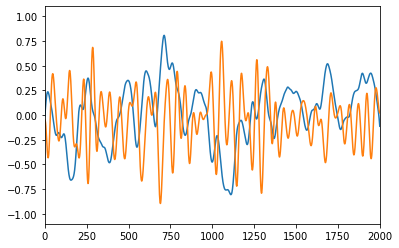

In [17]:
rx = rescale(x,1,-1)
rr = rescale(r,1,-1)
plt.plot(rx)
plt.plot(rr)
plt.xlim([0,2000])

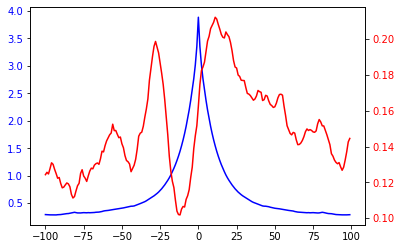

In [15]:
dms = range(-100,100)
mi_xx = [mi_quick(rx,rx,d) for d in dms]  
mi_xr = [mi_quick(rx,rr,d) for d in dms]

fig, ax1=plt.subplots()
ax1.plot(dms,mi_xx,'b')
ax1.tick_params(axis='y',labelcolor='b')
ax2=ax1.twinx()
ax2.plot(dms,mi_xr,'r')
ax2.tick_params(axis='y',labelcolor='r')